In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import h5py
from pathlib import Path

from sklearn.linear_model import Ridge,Lasso
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import flammkuchen as fl

from scipy.interpolate import interp1d

In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
from megabouts_helper import labels_cat, color

# Load Bouts

In [89]:
master_path = Path(r'\\portulab.synology.me\data\Kata\testdata\Raw_Data')

fish_paths = list(master_path.glob('*f[0-9]*'))
fish_paths, len(fish_paths)


([WindowsPath('//portulab.synology.me/data/Kata/testdata/Raw_Data/240423_f0')],
 1)

In [90]:
fish= 0
fish_path = fish_paths[fish]
fish_id =  fish_paths[fish].name#[:-13]
exp_name = Path(fish_paths[fish]).parts[-2]
exp_name = 'testfish'
exp_name, fish_id

('testfish', '240423_f0')

In [91]:
out_path = Path(r'\\portulab.synology.me\data\Kata\testdata\Processed_Data')

### Load DLC

In [92]:
fps=200
mm_per_unit = 1/70
N_seg = 10

In [93]:
df = pd.read_csv(master_path/ 'DLC_mod.csv', header=[0, 1])


In [94]:
df.head()

bodyparts left_eye_anterior                        left_eye_posterior  \
     coords                 x           y likelihood                  x   
0         0        645.326900  521.443017   0.999891         654.856002   
1         1        646.183150  519.644351   0.999896         656.078755   
2         2        650.207855  517.061760   0.999923         659.556388   
3         3        654.625610  513.145553   0.999913         664.477157   
4         4        657.924704  510.390997   0.999740         667.236973   

                         right_eye_anterior                         ...  \
            y likelihood                  x           y likelihood  ...   
0  553.228951   0.999758         606.735142  539.762843   0.999914  ...   
1  551.395331   0.999851         607.531952  537.669198   0.999881  ...   
2  549.311521   0.999905         611.376284  534.990023   0.999691  ...   
3  545.056029   0.999953         616.157773  530.418686   0.999719  ...   
4  542.307606   0.999960         619.216163  528.236603   0.999846  ...   

      tail_8      tail_9                            tail_10              \
  likelihood           x           y likelihood           x           y   
0   0.998467  463.398844  250.457989   0.998467  439.471039  239.365433   
1   0.998625  473.571332  246.601053   0.998625  444.348114  245.641525   
2   0.999190  491.481593  238.960160   0.999190  461.540009  236.261642   
3   0.997801  503.204287  227.416002   0.997801  476.081390  216.947006   
4   0.998626  506.768862  217.844257   0.998626  485.563690  199.774689   

                mid_head                         
  likelihood           x           y likelihood  
0   0.998467  633.807176  544.905587   0.998467  
1   0.998625  634.773111  542.948934   0.998625  
2   0.999190  638.426775  540.509511   0.999190  
3   0.997801  643.096984  536.308950   0.997801  
4   0.998626  646.209680  533.732044   0.998626  

[5 rows x 64 columns]

In [95]:
# df = df[(other_df.edge_filter.ok==True)&(other_df.DLC_filter.pos==1)]

In [96]:
print(f'{df.shape[0]/(fps*60)} minutes at {fps} fps')
print('working on {} frames'.format(df.shape[0]))

#Extract angles
body_x = df.body.values[:, 0].astype('float')
body_y = df.body.values[:, 1].astype('float')

tail_x_col = [f'tail_{i}' for i in range(N_seg)]
tail_y_col = [f'tail_{i}' for i in range(N_seg)]
tail_x = np.array([df[x].iloc[:, 0].values.astype('float') for x in tail_x_col])
tail_y = np.array([df[x].iloc[:, 1].values.astype('float') for x in tail_y_col])


7.9519166666666665 minutes at 200 fps
working on 95423 frames


In [97]:
head_x = df.mid_head.values[:, 0].astype('float') * mm_per_unit
head_y = df.mid_head.values[:, 1].astype('float') * mm_per_unit

In [98]:
head_x.shape, head_y.shape

((95423,), (95423,))

### Lets also apply edge filter and DLC filter

In [99]:
other_df = pd.read_csv(Path(out_path/ '{}_DLC.csv'.format(fish_id)), header=[0, 1])

In [100]:
df.shape

(95423, 64)

In [101]:
df[(other_df.edge_filter.ok==True)&(other_df.DLC_filter.pos==1)].shape

(95226, 64)

## Load data to compare with

In [102]:
data = fl.load(Path(out_path/ '{}_megabouts_res.h5'.format(fish_id)))
data = data['data']
print('working with {} detected bouts'.format(len(data['segments_on'])))

working with 500 detected bouts


C:\Users\admin\miniconda3\envs\megabouts\Lib\site-packages\tables\group.py:1192: UserWarning: problems loading leaf ``/data/fish_id``::

  variable length strings are not supported yet

The leaf will become an ``UnImplemented`` node.
  warnings.warn(


In [103]:
data.keys()

dict_keys(['body_angle', 'bout_category', 'bout_category_ts', 'clean_data_tail', 'eye_angles', 'eye_coords', 'fin_angles', 'fish_id', 'id_nearest_template', 'onset_shift', 'outlier', 'proba', 'rotation', 'segments_off', 'segments_on', 'tail_and_traj_array', 'tail_angle', 'tail_speed', 'tails_nearest', 'templates_labels', 'vergence'])

In [104]:
data['body_angle'].shape

(95423,)

In [105]:
segments_on = data['segments_on']
segments_off = data['segments_off']
bout_category_ts = data['bout_category_ts']

In [106]:
segments_on.shape, segments_off.shape, bout_category_ts.shape

((500,), (500,), (95423,))

In [107]:
# bout_data = fl.load(out_path/'{}_bout_data.h5'.format(fish_id))
# bout_data.keys()

In [108]:
features = pd.read_csv(out_path/'{}_features.csv'.format(fish_id))
features.shape

(500, 38)

In [109]:
clusters_pre = features.cluster.values
clusters_pre.shape

(500,)

In [110]:
features.head()

,exp,fish_id,bout_angle,cluster,frame_start,frame_end,bout_id_orig,mb_outlier,mb_proba,dlc_tracking_score,...,r_osc,tail_duration,t_start,t_end,l_fin_duration,l_start,l_end,r_fin_duration,r_start,r_end
0,testfish,240423_f0,15.573912,4.0,152,206,0,2.266837,0.466198,50,...,2,38.0,0.0,38.0,13.0,0.0,13.0,16.0,0.0,16.0
1,testfish,240423_f0,-3.338704,0.0,282,332,1,3.187149,0.464779,50,...,2,35.0,0.0,35.0,35.0,0.0,35.0,17.0,0.0,17.0
2,testfish,240423_f0,-22.208242,3.0,424,473,2,2.362387,0.504994,50,...,1,28.0,0.0,28.0,36.0,1.0,37.0,10.0,1.0,11.0
3,testfish,240423_f0,26.632259,5.0,821,866,3,2.416005,0.794203,50,...,1,30.0,0.0,30.0,7.0,5.0,12.0,21.0,0.0,21.0
4,testfish,240423_f0,-15.477214,2.0,1081,1129,4,2.298893,0.492508,50,...,1,37.0,0.0,37.0,13.0,0.0,13.0,11.0,1.0,12.0


## Run new Megabouts Pipeline

### Create tracking data

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from cycler import cycler

from megabouts.tracking_data import TrackingConfig, FullTrackingData, load_example_data
from megabouts.pipeline import FullTrackingPipeline
from megabouts.utils import (
    bouts_category_name,
    bouts_category_name_short,
    bouts_category_color,
    cmp_bouts,
)

In [112]:
# Load data and set tracking configuration
tracking_cfg = TrackingConfig(fps=fps, tracking="full_tracking")

# Compute head and tail coordinates and convert to mm
tail_x_col = [f'tail_{i}' for i in range(N_seg)]
tail_y_col = [f'tail_{i}' for i in range(N_seg)]
tail_x = np.array([df[x].iloc[:, 0].values.astype('float') for x in tail_x_col]) * mm_per_unit
tail_y = np.array([df[x].iloc[:, 1].values.astype('float') for x in tail_y_col]) * mm_per_unit
head_x = df.mid_head.values[:, 0].astype('float') * mm_per_unit
head_y = df.mid_head.values[:, 1].astype('float') * mm_per_unit


In [279]:
## compute body angle over whole experiment
body_x_ = np.asarray(df.body.values[:, 0].astype('float'))
body_y_ = np.asarray(df.body.values[:, 1].astype('float'))

head_x_ = np.asarray(df.mid_head.values[:, 0].astype('float'))
head_y_ = np.asarray(df.mid_head.values[:, 1].astype('float'))

In [280]:
import numpy as np

def compute_body_angle(head_x, head_y, body_x, body_y):
    """
    Computes the angle between two points in 2D space.
    
    Parameters:
    head_x, head_y: Coordinates of the first point (head).
    body_x, body_y: Coordinates of the second point (body).
    
    Returns:
    angles_radians: The angle in radians.
    angles_degrees: The angle in degrees.
    """
    # Calculate the differences in the x and y coordinates
    delta_x = body_x - head_x
    delta_y = body_y - head_y

    # Calculate the angle using numpy's arctan2
    angles_radians = np.arctan2(delta_y, delta_x)

    # Convert the angle from radians to degrees
    angles_degrees = np.degrees(angles_radians)

    return angles_radians, angles_degrees



angles_radians, angles_degrees = compute_body_angle(head_x_, head_y_, body_x_, body_y_)

print(f"Angles in radians: {angles_radians}")
print(f"Angles in degrees: {angles_degrees}")


Angles in radians: [-2.00363609 -2.00187956 -1.99634328 ... -2.95366955 -2.94051827
 -2.93854352]
Angles in degrees: [-114.79989141 -114.69924993 -114.38204466 ... -169.23279937 -168.47928621
 -168.36614146]


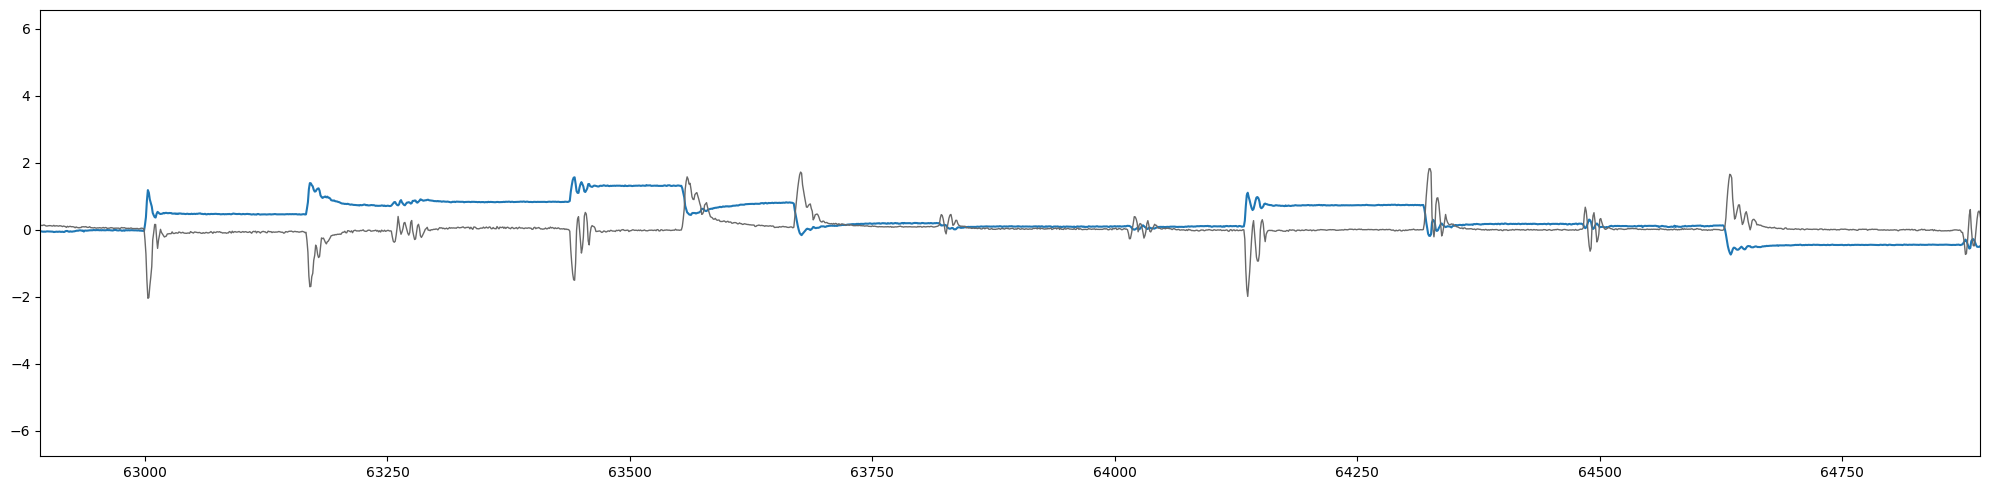

In [296]:
plt.figure(figsize=(20,5))
plt.plot(angles_radians)
# plt.plot(angles_degrees)
plt.plot(tracking_data._tail_angle[:, 7], c='dimgray', lw=1)
## set random start plus end winow
# Window size
window = 2000
# Generate a random number between 0 and n_rows - window
rand_int = random.randint(0, df.shape[0] - window)
plt.xlim(rand_int,rand_int+window)
plt.tight_layout()

In [113]:
tail_x.T.shape, tail_y.shape, head_x.shape, head_y.shape

((95423, 10), (10, 95423), (95423,), (95423,))

In [114]:
# Create FullTrackingData object
tracking_data = FullTrackingData.from_keypoints(
    head_x=head_x, head_y=head_y, tail_x=tail_x.T, tail_y=tail_y.T
)

In [115]:
pipeline = FullTrackingPipeline(tracking_cfg, exclude_CS=True)

In [116]:
pipeline.segmentation_cfg.threshold = 20

In [117]:
pipeline.tail_preprocessing_cfg.tail_speed_filter_ms = 50

In [233]:
# pipeline.segmentation_cfg.bout_duration = 50

In [234]:
pipeline.tail_preprocessing_cfg

TailPreprocessingConfig(fps=200, limit_na_ms=100, num_pcs=4, savgol_window_ms=15, baseline_method='median', baseline_params={'fps': 200, 'half_window': 100}, tail_speed_filter_ms=50, tail_speed_boxcar_filter_ms=14)

In [119]:
ethogram, bouts, segments, tail, traj = pipeline.run(tracking_data)

C:\Users\admin\miniconda3\envs\megabouts\Lib\site-packages\megabouts\classification\classification.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(t

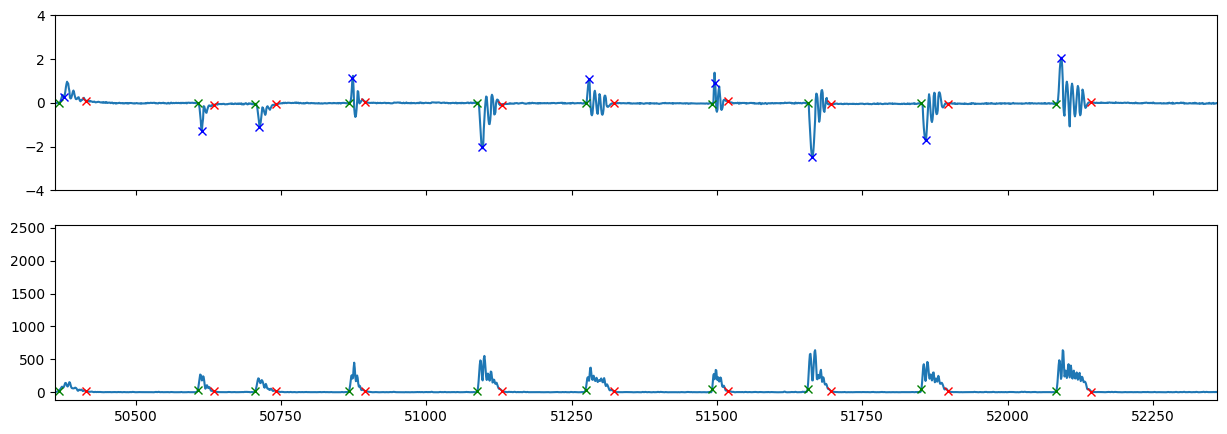

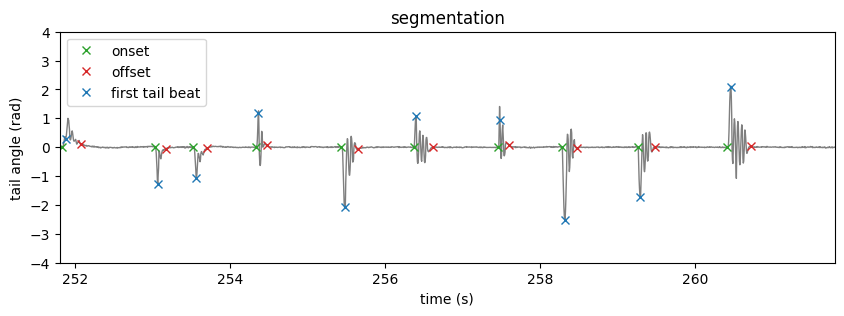

In [120]:
fig, ax = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

x = tracking_data._tail_angle[:, 7]
ax[0].plot(x)
ax[0].plot(segments.onset, x[segments.onset], "x", color="green")
ax[0].plot(segments.offset, x[segments.offset], "x", color="red")
ax[0].plot(segments.HB1, x[segments.HB1], "x", color="blue")
ax[0].set_ylim(-4, 4)

x = tail.vigor
ax[1].plot(x)
ax[1].plot(segments.onset, x[segments.onset], "x", color="green")
ax[1].plot(segments.offset, x[segments.offset], "x", color="red")

t = np.arange(tracking_data.T) / tracking_cfg.fps
IdSt = np.random.randint(tracking_data.T)
Duration = 10 * tracking_cfg.fps
ax[1].set_xlim(IdSt, IdSt + Duration)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
x = tail.df.angle_smooth.iloc[:, 7]
ax.plot(t, x, color="tab:grey", lw=1)
ax.plot(t[segments.onset], x[segments.onset], "x", color="tab:green", label="onset")
ax.plot(t[segments.offset], x[segments.offset], "x", color="tab:red", label="offset")
ax.plot(
    t[segments.HB1], x[segments.HB1], "x", color="tab:blue", label="first tail beat"
)
ax.set(
    **{
        "title": "segmentation",
        "xlim": (t[IdSt], t[IdSt + Duration]),
        "ylim": (-4, 4),
        "ylabel": "tail angle (rad)",
        "xlabel": "time (s)",
    }
)
ax.legend()
plt.show()

## Number of bouts detected comparable?
    Similar number of bouts detected. 
    Probably difference could be accounted for by edge filter and DLC filter? Only 1.
    Then it may be that the new detection is more sensitive

In [206]:
seg_on = segments.onset
seg_off = segments.offset

seg_on.shape, seg_off.shape, segments_on.shape, segments_off.shape

((506,), (506,), (500,), (500,))

## Visualise results

In [229]:
pipeline.segmentation_cfg.bout_duration

40

(342,)


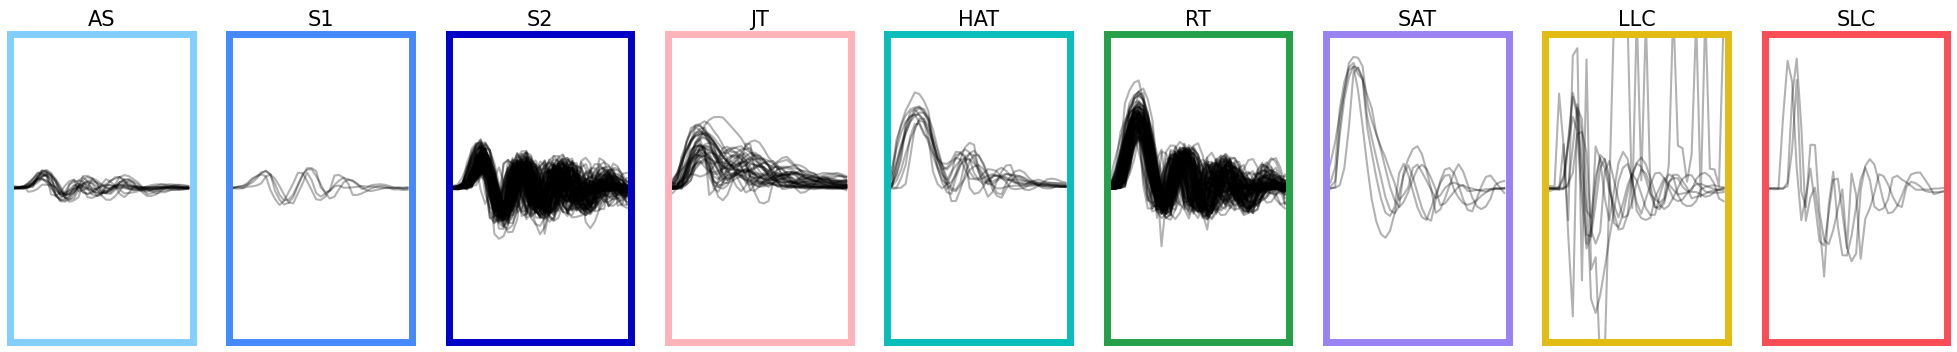

In [227]:
thr_proba = 0.9

id_b = np.unique(bouts.df.label.category[bouts.df.label.proba > thr_proba]).astype("int")
print(bouts.df.label.category[bouts.df.label.proba > thr_proba].shape)
fig, ax = plt.subplots(facecolor="white", figsize=(25, 4))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
G = gridspec.GridSpec(1, len(id_b))
ax0 = {}
for i, b in enumerate(id_b):
    ax0 = plt.subplot(G[i])
    ax0.set_title(bouts_category_name_short[b], fontsize=15)
    for i_sg, sg in enumerate([1, -1]):
        id = bouts.df[
            (bouts.df.label.category == b)
            & (bouts.df.label.sign == sg)
            & (bouts.df.label.proba > thr_proba)
        ].index
        if len(id) > 0:
            ax0.plot(sg * bouts.tail[id, 7, :].T, color="k", alpha=0.3)
        ax0.set_xlim(0, pipeline.segmentation_cfg.bout_duration)
        ax0.set_ylim(-4, 4)
        ax0.set_xticks([])
        ax0.set_yticks([])
        for sp in ["top", "bottom", "left", "right"]:
            ax0.spines[sp].set_color(bouts_category_color[b])
            ax0.spines[sp].set_linewidth(5)

plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_24180\3850899793.py:27: PerformanceWarning: indexing past lexsort depth may impact performance.
  ethogram.df[("bout", "cat")].values[IdSt:IdEd].T,
C:\Users\admin\AppData\Local\Temp\ipykernel_24180\3850899793.py:44: PerformanceWarning: indexing past lexsort depth may impact performance.
  id_b = np.unique(ethogram.df[("bout", "id")].values[IdSt:IdEd]).astype("int")


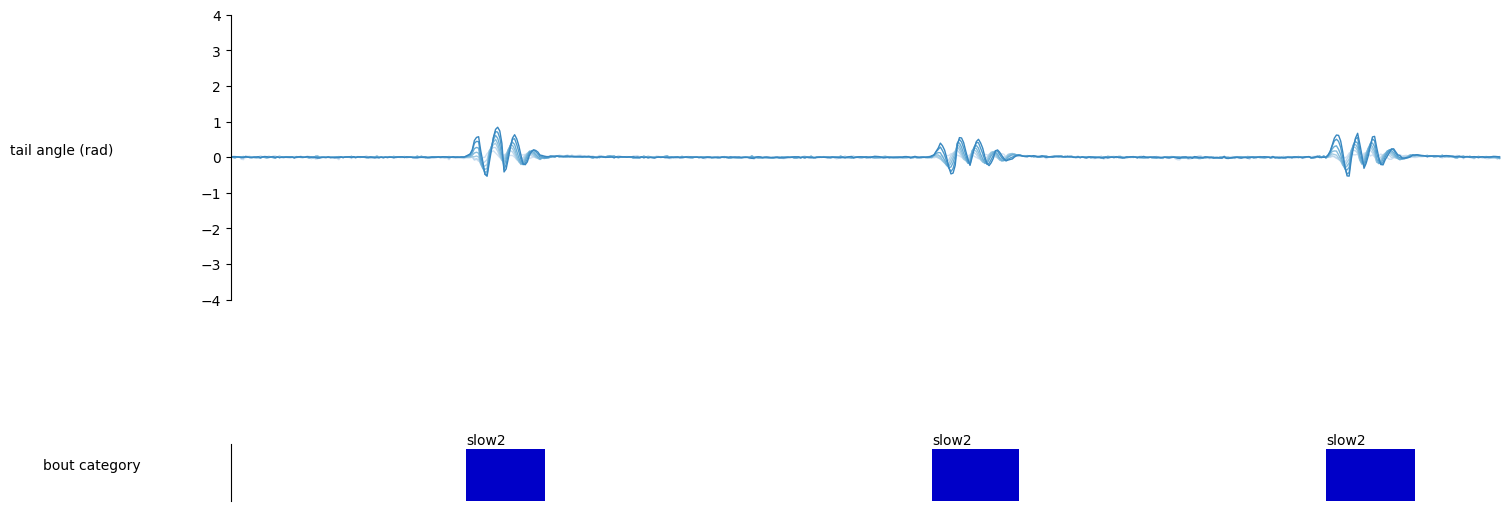

In [123]:
IdSt = np.random.randint(tracking_data.T)
T = 3
Duration = T * tracking_cfg.fps
IdEd = IdSt + Duration
t = np.arange(Duration) / tracking_cfg.fps


fig = plt.figure(facecolor="white", figsize=(15, 5), constrained_layout=True)
G = gridspec.GridSpec(2, 1, height_ratios=[1, 0.2], hspace=0.5, figure=fig)
ax = plt.subplot(G[0, 0])
blue_cycler = cycler(color=plt.cm.Blues(np.linspace(0.2, 0.9, 10)))
ax.set_prop_cycle(blue_cycler)

ax.plot(t, ethogram.df["tail_angle"].values[IdSt:IdEd, :7], lw=1)
ax.set_ylim(-4, 4)
ax.set_xlim(0, T)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.get_yaxis().tick_left()
ax.get_xaxis().set_ticks([])
ax.set_ylabel("tail angle (rad)", rotation=0, labelpad=100)

ax = plt.subplot(G[1, 0])
ax.imshow(
    ethogram.df[("bout", "cat")].values[IdSt:IdEd].T,
    cmap=cmp_bouts,
    aspect="auto",
    vmin=0,
    vmax=12,
    interpolation="nearest",
    extent=(0, T, 0, 1),
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.get_yaxis().tick_left()
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_xlim(0, T)
ax.set_ylim(0, 1.1)

id_b = np.unique(ethogram.df[("bout", "id")].values[IdSt:IdEd]).astype("int")
id_b = id_b[id_b > -1]
for i in id_b:
    on_ = bouts.df.iloc[i][("location", "onset")]
    b = bouts.df.iloc[i][("label", "category")]
    ax.text((on_ - IdSt) / tracking_cfg.fps, 1.1, bouts_category_name[int(b)])

ax.set_ylabel("bout category", rotation=0, labelpad=100)
plt.show()

#### Create new megabouts_res.h5

In [316]:

megabouts_res = dict({
    'segments_on': np.asarray(segments.onset),
    'segments_off': np.asarray(segments.offset),
    'cluster_n_vector': np.asarray(ethogram.df[("bout", "cat")].values),
    'clusters':  np.asarray(bouts.df.label.category),
    'laterality' :np.asarray(bouts.df.label.sign),
    'proba' :np.asarray(bouts.df.label.proba),
    
    'clean_data_tail':np.asarray(ethogram.df["tail_angle"].values),
    'body_angle_rad' :np.asarray(angles_radians),
    'body_angle_rad' :np.asarray(angles_degrees),
    'head_angle_mb' :np.asarray(traj.yaw_smooth),
    'duration' : np.asarray(bouts.df.location.offset - bouts.df.location.onset),
    'bouts_df': bouts.df, 
    'ethogram_df': ethogram.df,
})
fl.save(out_path/'{}_megabouts_res.h5'.format(fish_id), megabouts_res)

C:\Users\admin\AppData\Local\Temp\ipykernel_24180\2363197304.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  'cluster_n_vector': np.asarray(ethogram.df[("bout", "cat")].values),


## Visualise the whole experiment at once

In [151]:
ethogram.df[("bout", "cat")].values.shape, np.unique(ethogram.df[("bout", "cat")].values)

C:\Users\admin\AppData\Local\Temp\ipykernel_24180\3731104286.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  ethogram.df[("bout", "cat")].values.shape, np.unique(ethogram.df[("bout", "cat")].values)


((95423, 1), array([-1,  0,  1,  2,  5,  6,  7,  8,  9, 11, 12]))

In [152]:
bouts_category_color

['#82cfff',
 '#4589ff',
 '#0000c8',
 '#5d5d66',
 '#000000',
 '#fcaf6d',
 '#ffb3b8',
 '#08bdba',
 '#24a148',
 '#9b82f3',
 '#ee5396',
 '#e3bc13',
 '#fa4d56']

In [189]:
bouts.df.label.category

0      2.0
1      2.0
2      8.0
3      8.0
4      2.0
      ... 
501    2.0
502    8.0
503    2.0
504    8.0
505    7.0
Name: category, Length: 506, dtype: float64

In [157]:
df.shape[0]

95423

C:\Users\admin\AppData\Local\Temp\ipykernel_24180\530847303.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  axes[0].axvspan(onset, offset, color=bouts_category_color[int(ethogram.df[("bout", "cat")].values[onset])], alpha=.3)
C:\Users\admin\AppData\Local\Temp\ipykernel_24180\530847303.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axes[0].axvspan(onset, offset, color=bouts_category_color[int(ethogram.df[("bout", "cat")].values[onset])], alpha=.3)


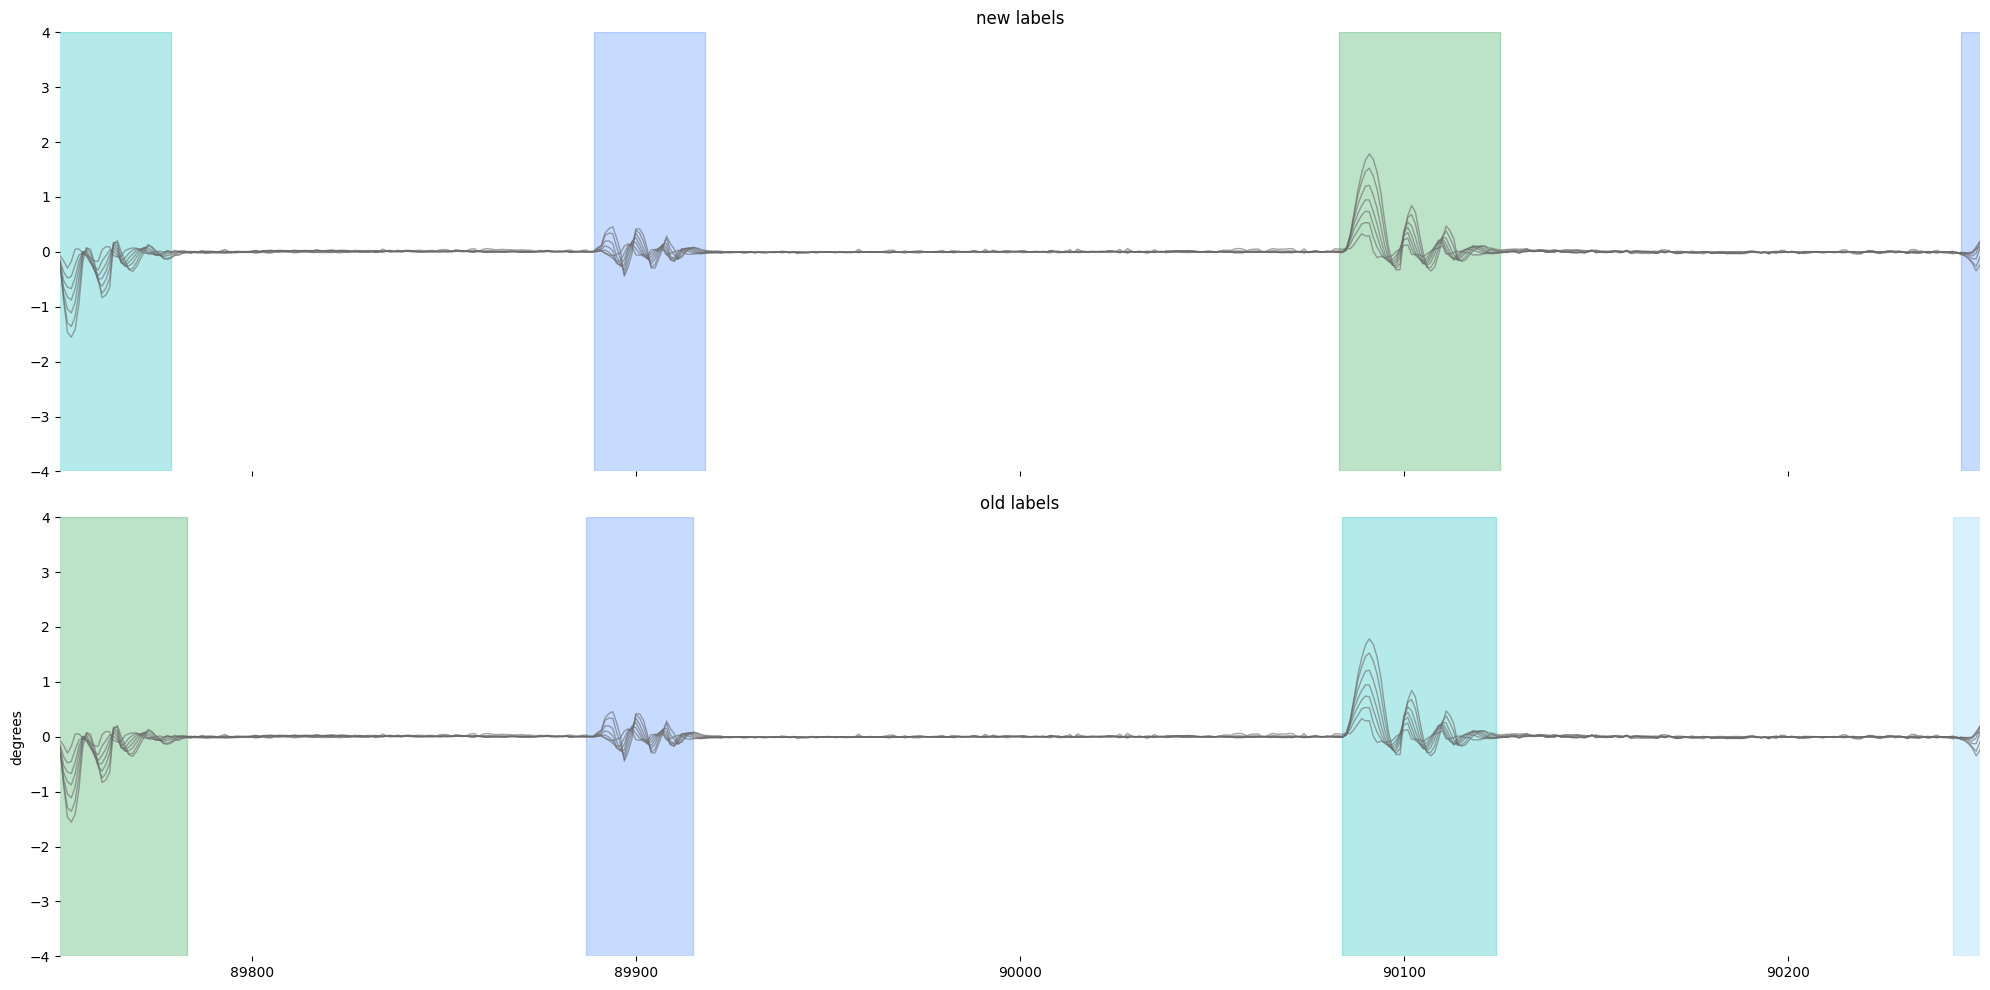

In [202]:
import random

fig, axes = plt.subplots(2,1, figsize=(20,10), sharex=True, sharey=True)
axes = axes.ravel()

axes[0].plot(ethogram.df["tail_angle"].values[:, :7], lw=1, c='dimgray', alpha=0.6)
axes[0].set_title('new labels')

for onset, offset in zip(seg_on, seg_off):
    axes[0].axvspan(onset, offset, color=bouts_category_color[int(ethogram.df[("bout", "cat")].values[onset])], alpha=.3)


axes[1].plot(ethogram.df["tail_angle"].values[:, :7], lw=1, c='dimgray', alpha=0.6)
axes[1].set_title('old labels')

axes[1].set_ylabel('degrees')
axes[1].set_ylim(-4,  4)

##very first version mb labels
# for onset, offset in zip(segments_on, segments_off):
    # axes[1].axvspan(onset, offset, color=color[int(bout_category_ts[onset])], alpha=.3)

# recleassification with new mb labels
for ind, (onset, offset) in enumerate(zip(segments_on, segments_off)):
    axes[1].axvspan(onset, offset, color=color[int(clusters_pre[ind])], alpha=.3)


## set random start plus end winow
# Window size
window = 500
# Generate a random number between 0 and n_rows - window
rand_int = random.randint(0, df.shape[0] - window)
axes[0].set_xlim(rand_int,rand_int+window)

sns.despine(top=True, right=True, left=True, bottom=True)
plt.tight_layout()

# fig.savefig(out_path/ 'plots' /'{}_comparison_pipelines_mb.png'.format(fish_id), dpi=300)

## Cpmparative heatmap

    Problem: different number of bouts. Need to be matched by time somehow before? Difficult because different cropping

In [192]:
clusters_new = bouts.df.label.category

In [194]:
# assuming clusters_pre and clusters_new are your list data
# df = pd.DataFrame({'clusters_pre': clusters_pre, 'clusters_new': clusters_new})

In [195]:
## numbers have to be reassigned in old one to match names -> 
# clusters_new_names = bouts_category_name
# clusters_pre_names = labels_cat + ['None1', 'None2']

In [196]:
translation_dict_new = {0: 'approach_swim', 1: 'slow1', 2: 'slow2', 3: 'short_capture_swim', 4: 'long_capture_swim', 5: 'burst_swim', 6: 'J_turn', 7: 'high_angle_turn', 
                        8: 'routine_turn', 9: 'spot_avoidance_turn', 10: 'O_bend', 11: 'long_latency_C_start', 12: 'short_latency_C_start'}
translation_dict_pre = {0: 'approach_swim', 1: 'slow1', 2: 'slow2', 3: 'burst_swim', 4: 'J_turn', 5: 'high_angle_turn', 6: 'routine_turn', 7: 'spot_avoidance_turn', 8: 'O_bend', 9: 'long_latency_C_start', 10: 'short_latency_C_start'}


In [197]:
# # Convert dictionaries into dataframes
# df_pre = pd.DataFrame(list(translation_dict_pre.items()),columns = ['Id_pre','Name']) 
# df_new = pd.DataFrame(list(translation_dict_new.items()),columns = ['Id_new','Name'])

# # Merge dataframes based on the 'Name' column
# translation_matrix = pd.merge(df_pre, df_new, on='Name', how='outer')
# final_df = translation_matrix.sort_values(by=['Id_pre'], ascending=True)
# print(final_df)


In [198]:
# old_labels = []
# new_labels = []

# for i, j in zip(clusters_pre, clusters_new):
#     old_labels.append(final_df['Name'][final_df['Id_pre']==i].values[0])
#     new_labels.append(final_df['Name'][final_df['Id_new']==j].values[0])

In [199]:
# def count_label_changes(old_labels, new_labels):
#     # Make sure both lists have the same length
#     assert len(old_labels) == len(new_labels), "Label lists are not the same length"
    
#     # Initialize counters
#     same_label_count = 0
#     changed_label_count = 0
    
#     # Loop through both lists simultaneously
#     for old, new in zip(old_labels, new_labels):
#         # Increase the appropriate counter
#         if old == new:
#             same_label_count += 1
#         else:
#             changed_label_count += 1
    
#     return same_label_count, changed_label_count


# same, changed = count_label_changes(old_labels, new_labels)
# print(f'Same Labels: {same}, Changed Labels: {changed}')


In [200]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# def create_change_matrix(old_labels, new_labels):
#     # Make sure both lists have the same length
#     assert len(old_labels) == len(new_labels), "Label lists are not the same length"

#     # Create a DataFrame to store changes
#     df_changes = pd.DataFrame({'Old': old_labels, 'New': new_labels})

#     # Create a pivot table with counts of changes
#     change_matrix = df_changes.groupby(['Old', 'New']).size().unstack(fill_value=0)

#     # Convert counts to percentages
#     change_matrix = change_matrix.div(change_matrix.sum(axis=1), axis=0)

#     return change_matrix

# def plot_sorted_heatmap(change_matrix, final_df):
#     # Sort the change_matrix based on the order in final_df
#     sorted_labels = final_df['Name'].unique()
#     change_matrix = change_matrix.reindex(index=sorted_labels, columns=sorted_labels, fill_value=0)

#     # Plot a heatmap
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(change_matrix, annot=True, fmt=".2f", cmap='YlGnBu')
#     plt.title("Sorted Label Change Heatmap")
#     plt.xticks(rotation=90)
#     plt.yticks(rotation=0)
#     plt.savefig(Path( save_figure_path/ 'heatmap_megabouts_res.png'), dpi=350)
    

# change_matrix = create_change_matrix(old_labels, new_labels)
# plot_sorted_heatmap(change_matrix, final_df)